In [30]:
import os, time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.signal import resample

from joblib import dump

In [31]:
SAMPLE_POINTS = 50
INPUT_PARAMETERS = 3

SCRIPT_DIR = os.path.abspath('') #os.path.dirname(__file__); workaround for jupyter notebook

DATA_PATH = os.path.join(SCRIPT_DIR, "data")

In [32]:
data: list[tuple[str, list[tuple]]] = []

In [33]:
def get_data(path: str, data_list: list) -> None:
  for *_, files in os.walk(path):
    if len(files) == 0:
      continue

    for file_name in files:
      if not file_name.endswith(".csv"):
        continue

      file_path = os.path.join(path, file_name)

      data = pd.read_csv(filepath_or_buffer=file_path, delimiter=",")

      points = data[["accelerometer_x", "accelerometer_y", "accelerometer_z"]]
      points = np.array(points, dtype=float)
      class_name = data["gesture"][0]

      scaler = StandardScaler()
      points = scaler.fit_transform(points)

      points_resampled = resample(points, SAMPLE_POINTS)

      data_list.append((class_name, points_resampled))

In [34]:
get_data(DATA_PATH, data)

In [35]:
print(data[0])

('TILT_RIGHT', array([[-1.31934268, -1.08503094,  1.09373827],
       [-2.23294472, -0.97566626,  1.61468653],
       [-1.89005348, -1.03630838,  1.50686282],
       [-2.05030092, -0.7451457 ,  1.58347781],
       [-1.99381833, -1.45814623,  1.58230097],
       [-2.08065502, -1.48109573,  1.55702359],
       [-2.06096472, -1.36854517,  1.66657464],
       [-1.82254829, -0.68121349,  1.41572286],
       [-1.58840221, -0.48182763,  1.53167251],
       [-1.23222895, -0.53774059,  1.15098677],
       [-0.82412167, -1.57860106,  0.97033342],
       [-0.84973665, -0.52611508,  1.13357507],
       [-0.42588352, -0.28711225,  0.78698819],
       [-0.24168589,  1.27229701,  0.82073127],
       [ 0.11189502,  1.02768708,  0.41142094],
       [ 0.24605798,  2.07846527,  0.56526053],
       [ 0.32059091,  1.37252397,  0.40747154],
       [ 0.16228912,  1.27306688,  0.55707387],
       [ 0.44044124, -0.13674316,  0.30949271],
       [ 0.56125799,  0.55538127, -0.25741621],
       [ 0.58461181,  0.5

In [36]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


{'TILT_RIGHT', 'NEUTRAL', 'THROW', 'TILT_LEFT'}
{0, 1, 2, 3}
4
(896, 50, 3) (225, 50, 3) (896, 4) (225, 4)


using joblib to save encoding to a file and later pick it up for the recogniser.py to assign encoded labels to correct name.

In [37]:
dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [38]:
class NN:   

  def __init__(self) -> None:
    self.model = Sequential()

    self.model.add(LSTM(64, input_shape=(SAMPLE_POINTS, INPUT_PARAMETERS)))
    self.model.add(Dense(32, activation="tanh"))

    self.model.add(Dense(len(set(labels)), activation='softmax'))

    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    self.stop_early = EarlyStopping(monitor='val_loss', patience=3)

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> None:
    # Train the model
    self.history = self.model.fit(
      X_train,
      y_train,
      epochs=24,
      batch_size=24,
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=[self.reduce_lr, self.stop_early]
    )

  def summarise(self) -> None:
    self.model.summary()

  def plot(self) -> None:
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    accuracy = self.history.history['accuracy']
    val_accuracy = self.history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

  def predict(self, X_test: np.ndarray, y_test: np.ndarray, labels_train: list[str]) -> None:
    # let the model make predictions for our training data
    y_predictions = self.model.predict(X_test)
    

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_train)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')

In [39]:
nn = NN()
nn.train(X_train, y_train, X_test, y_test)


Epoch 1/24
38/38 [==============================] - 6s 45ms/step - loss: 1.2753 - accuracy: 0.3906 - val_loss: 1.1123 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/24
38/38 [==============================] - 1s 24ms/step - loss: 0.8377 - accuracy: 0.7042 - val_loss: 0.5833 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 3/24
38/38 [==============================] - 1s 25ms/step - loss: 0.3721 - accuracy: 0.8795 - val_loss: 0.2852 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 4/24
38/38 [==============================] - 1s 27ms/step - loss: 0.2515 - accuracy: 0.9062 - val_loss: 0.2362 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 5/24
38/38 [==============================] - 1s 31ms/step - loss: 0.2152 - accuracy: 0.9252 - val_loss: 0.3106 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 6/24
38/38 [==============================] - 1s 30ms/step - loss: 0.1812 - accuracy: 0.9397 - val_loss: 0.2069 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 7/24
38/38 [==============================] - 1s 28ms/step - loss: 0.1

In [40]:
nn.summarise()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 19620 (76.64 KB)
Trainable params: 19620 (76.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


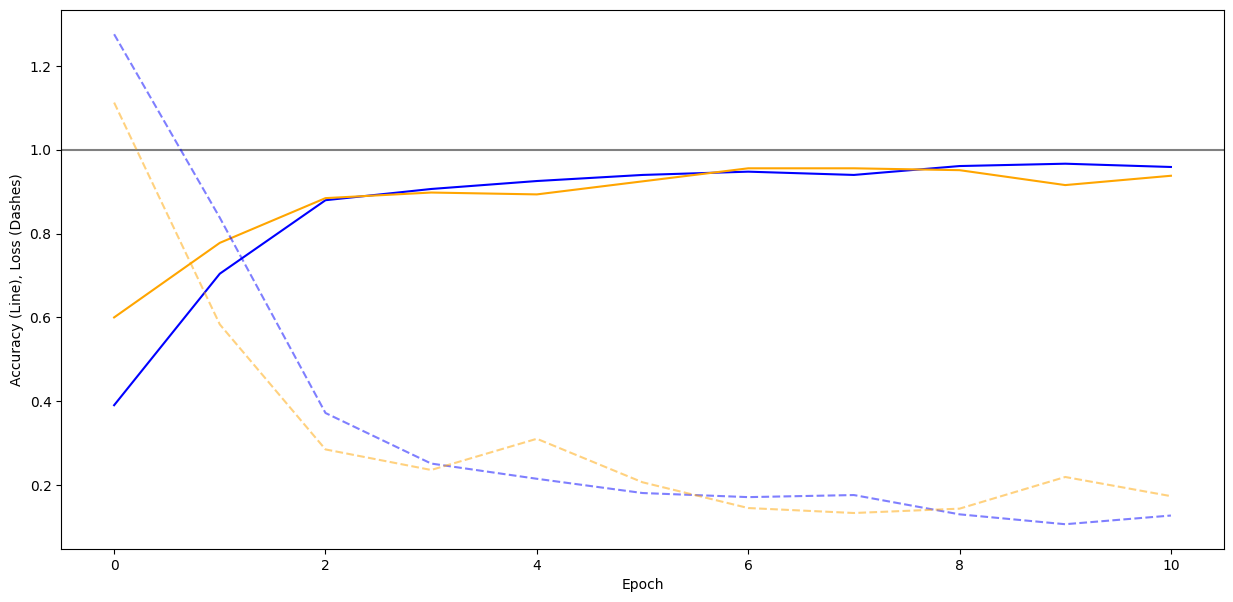

In [41]:
nn.plot()

8/8 [==============================] - 1s 8ms/step


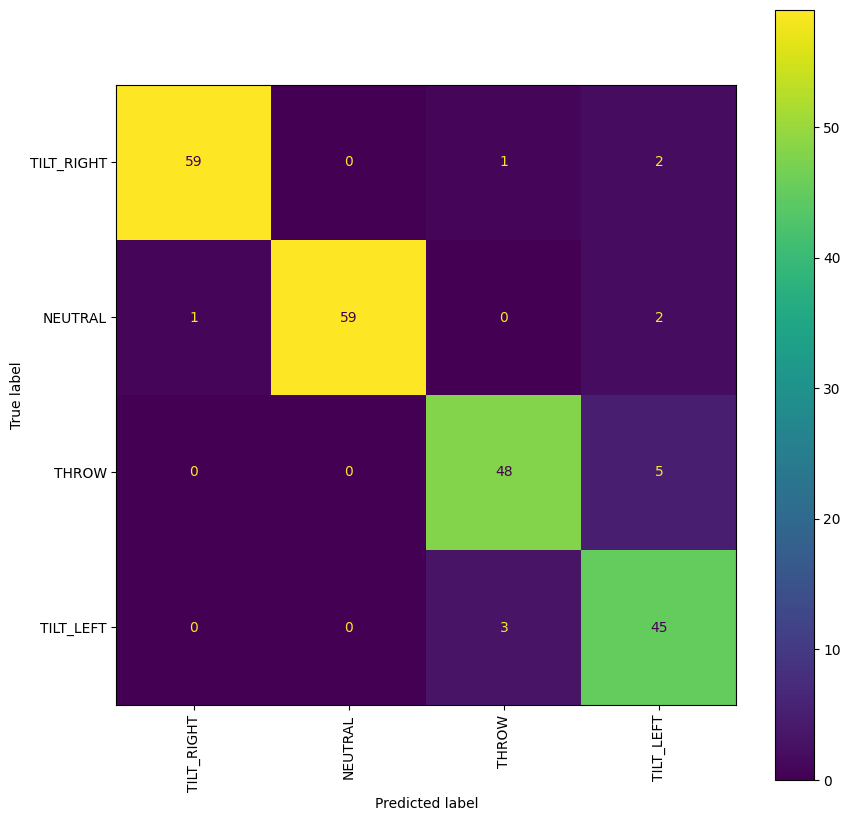

In [42]:
nn.predict(X_test, y_test, labels)

In [43]:
nn.model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets
